In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#change to your datapath
%cd /content/drive/MyDrive/EAI/Lab3

/content/drive/MyDrive/EAI/Lab3


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from resnet18 import *

In [ ]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [ ]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [ ]:
# setting parameter
EPOCH = 55
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
device = torch.device("cuda")

In [ ]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78427020acb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78427020acb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[0.49117824 0.4814862  0.44613206] [0.24773838 0.24419191 0.26171857]
[0.49117824 0.4814862  0.44613206] [0.24773838 0.24419191 0.26171857]


In [ ]:
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(train_mean,train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(test_mean,test_std)
])

In [ ]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
#image, label = trainset[0]
#print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [ ]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler


    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.858 | Train acc: 0.312
Val loss: 1.793 | Val acc: 0.351

Epoch: 2
learning rate:  0.05
Train loss: 1.513 | Train acc: 0.441
Val loss: 1.726 | Val acc: 0.373

Epoch: 3
learning rate:  0.05
Train loss: 1.347 | Train acc: 0.506
Val loss: 1.256 | Val acc: 0.534

Epoch: 4
learning rate:  0.05
Train loss: 1.203 | Train acc: 0.563
Val loss: 1.377 | Val acc: 0.513

Epoch: 5
learning rate:  0.05
Train loss: 1.119 | Train acc: 0.598
Val loss: 1.335 | Val acc: 0.530

Epoch: 6
learning rate:  0.05
Train loss: 1.042 | Train acc: 0.630
Val loss: 1.107 | Val acc: 0.607

Epoch: 7
learning rate:  0.05
Train loss: 0.989 | Train acc: 0.650
Val loss: 1.074 | Val acc: 0.613

Epoch: 8
learning rate:  0.05
Train loss: 0.941 | Train acc: 0.667
Val loss: 1.019 | Val acc: 0.643

Epoch: 9
learning rate:  0.05
Train loss: 0.900 | Train acc: 0.680
Val loss: 0.992 | Val acc: 0.645

Epoch: 10
learning rate:  0.025
Train loss: 0.856 | Train acc: 0.697
Val loss: 0.903 | Val

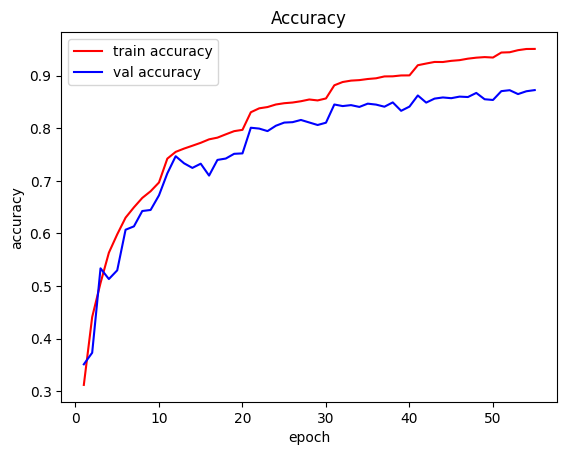

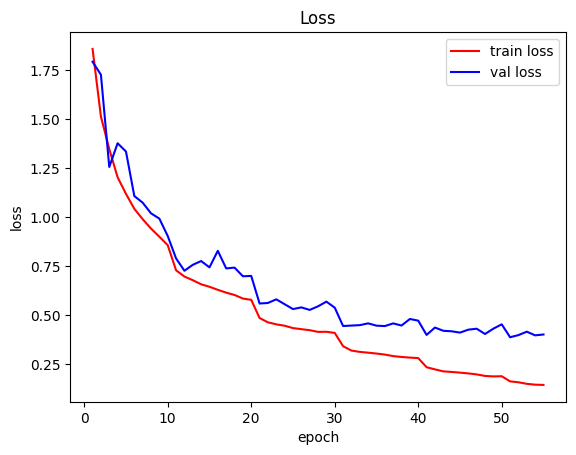

In [48]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()